In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os

import pandas as pd

from scipy import stats

import ipywidgets as widgets
from ipywidgets import interactive

/home/valentin/.local/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
gnss = pd.read_csv('MUCKENBACH_OP_2024.csv')
gnss['geophone'] = gnss['Name'].map(lambda e: int(e.split('.')[-1]))
gnss = gnss.set_index('geophone')
gnss = gnss.sort_index()
gnss.head()

,Name,Latitude,Longitude,EllipsoidHeight,TimeStamp,X,Y,A
geophone,,,,,,,,
1,ONDEP.GR1.1,48.491419,7.288735,713.297247,2024-09-05T11:13:58.140,6.829844e+06,1.016730e+06,664.559143
2,ONDEP.GR1.2,48.491409,7.288722,713.355544,2024-09-05T11:14:17.490,6.829843e+06,1.016729e+06,664.617394
3,ONDEP.GR1.3,48.491398,7.288709,713.314836,2024-09-05T11:14:34.570,6.829841e+06,1.016728e+06,664.576637
4,ONDEP.GR1.4,48.491388,7.288697,713.351575,2024-09-05T11:14:51.520,6.829840e+06,1.016727e+06,664.613325
5,ONDEP.GR1.5,48.491377,7.288685,713.299571,2024-09-05T11:15:07.390,6.829839e+06,1.016726e+06,664.561276


Text(0, 0.5, 'Northing (m)')

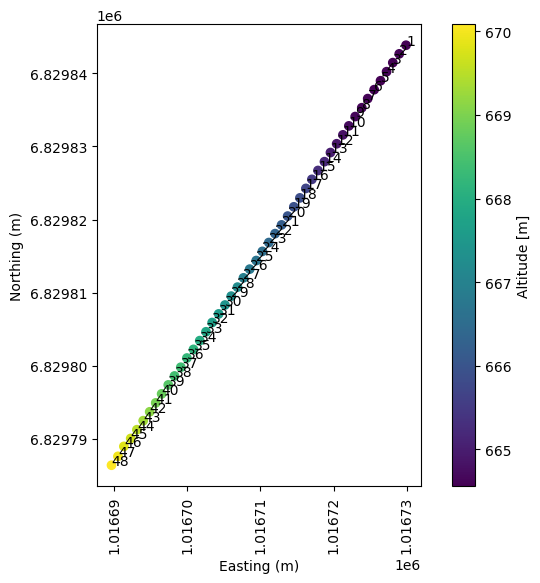

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for k, row in enumerate(gnss.iterrows()):
    k, serie = row
    plt.annotate(k, (serie[' Y '], serie[' X ']))
ax.set_aspect('equal', adjustable='box')

im = plt.scatter(gnss[' Y '], gnss[' X '], c=gnss['A'])
cb = plt.colorbar(im, label='Altitude [m]')

ax.get_yaxis().get_major_formatter().set_useOffset(False)
ax.get_xaxis().get_major_formatter().set_useOffset(False)
plt.xticks(rotation=90)
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')

In [4]:
df = pd.read_csv('picking2.csv')
df.head()

,FB_TIME,FB_TIME_QLTY,OFFSET,REC_ELEV,REC_X,SRC_X
0,51.770000,62.677216,-71.0,5.52,70.5,-0.75
1,51.554585,13.251684,-69.0,5.41,69.0,-0.75
2,52.690189,4.282903,-68.0,5.25,67.5,-0.75
3,53.303646,31.785852,-66.0,5.12,66.0,-0.75
4,53.610374,40.457558,-65.0,4.95,64.5,-0.75


In [5]:
x_geoph = df['REC_X'].unique()
x_geoph.sort()
x_shots = df['SRC_X'].unique()
x_shots.sort()
ng = len(df['REC_X'].unique())
ns = len(df['SRC_X'].unique())
dx = 1.5
offset = .75

In [6]:
profil = df[['REC_X', 'REC_ELEV']].drop_duplicates(subset=['REC_X']).values # positions x, z des géophones
profil = profil[profil[:, 0].argsort()]

Text(0, 0.5, 'x [m]')

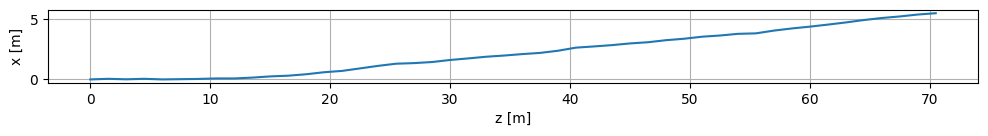

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12, 2))
plt.plot(profil[:, 0], profil[:, 1])
plt.grid()
ax.set_aspect('equal', adjustable='box')
plt.xlabel('z [m]')
plt.ylabel('x [m]')

In [8]:
x = np.concatenate((x_geoph, x_shots))
x.sort()

y = np.interp(x, profil[:, 0], profil[:, 1]) # interpolation de l'altitude des capteurs (mesurées) pour estimer celle des sources
xy = np.array((x, y)).T # positions de tous les capteurs et receveurs

In [9]:
print('Nombre de geophones', ng)
print('Nombre de shots (sources)', ns)
print('Nombre total de positions', len(xy))
print('Nombre total de données', ns*ng)

Nombre de geophones 48
Nombre de shots (sources) 49
Nombre total de positions 97
Nombre total de données 2352


In [10]:
s = np.int64((df['SRC_X'].values+.75)/1.5*2+1) # indices impaires (1, 3...)
g = np.int64(df['REC_X'].values/1.5*2+2) # indices pairs (2, 4...)
t = df['FB_TIME'].values/1000 +.05 # ms to s

In [11]:
find_index = lambda v: np.where(x == v)[0][0] + 1 # pygimli index starts at 1 instead of 0 in python
s = df['SRC_X'].map(find_index).values
g = df['REC_X'].map(find_index).values

In [12]:
pos_shots = xy[np.unique(s) - 1]
pos_geoph = xy[np.unique(g) - 1]

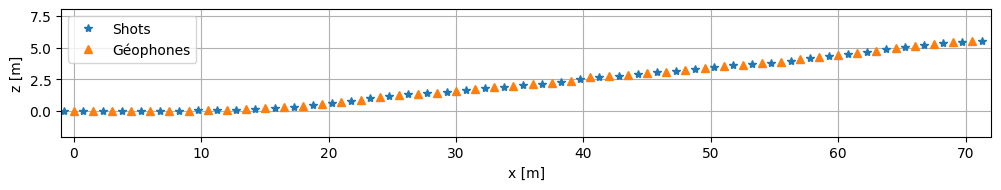

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 2))
plt.plot(pos_shots[:, 0], pos_shots[:, 1], '*', label='Shots')
plt.plot(pos_geoph[:, 0], pos_geoph[:, 1], '^', label='Géophones')
plt.grid()
ax.set_aspect('equal', adjustable='box')
plt.xlabel('x [m]')
plt.ylabel('z [m]')
plt.xlim(-1, 72)
plt.ylim(-2, 8)
plt.legend()

In [14]:
with open('data.sgt', 'w') as f:
    f.write(f'{len(xy)} # shot/geophone points\n')
    f.write('#x	y\n')
    #f.write(open('xy', 'r').read())
    for pos in xy:
        x, y = pos
        f.write(f'{x} {y}\n')
    f.write(f'{len(t)} # measurements\n')
    f.write('#s	g	t\n')
    #f.write(open('sgt', 'r').read())
    for i in range(len(t)):
        f.write(f'{s[i]} {g[i]} {t[i]}\n')

In [15]:
def scatterplt(choosen_shot=12.75, geophones=[0, -1]):
    
    ii = np.where(xy[s-1][:, 0] == choosen_shot)
    xgeoph = xy[g[ii]-1][:, 0]
    times = t[ii]
    jj = np.where((xgeoph >= geophones[0]) & (xgeoph <= geophones[1]))
    xreg = xgeoph[jj]
    tslice = times[jj]
    slope, intercept, r, p, std_err = stats.linregress(xreg, tslice)
    treg = slope * xreg + intercept
    print(f'v={1/slope} m/s')
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 2))
    
    ax.scatter(choosen_shot, 0, c='red', marker='*')
    ax.scatter(xgeoph, [0]*len(xgeoph), c='green', marker='^')
    ax.scatter(xgeoph, times, c='black', marker='+')
    plt.axvline(geophones[0], linestyle=':', color='grey')
    plt.axvline(geophones[1], linestyle=':', color='grey')
    ax.plot(xreg, treg, c='blue', label=f'v={np.abs(1/slope):.1f} m/s')
    ax.set_xlabel('Distance [m]')
    ax.set_ylabel('Traveltime [m]')
    ax.legend()
    ax.invert_yaxis()
    
    plt.show()

In [16]:
interactive_plot = interactive(scatterplt, choosen_shot=widgets.SelectionSlider(
    options=list(x_shots),
    value=x_shots[ns//2],
    description='Position du shot',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
), geophones=widgets.IntRangeSlider(
    value=[x_geoph[0], x_geoph[ng//3]],
    min=np.min(x_geoph),
    max=np.max(x_geoph),
    step=dx,
    description='Geophones',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
))
interactive_plot

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.
